## Краткое описание проекта - провести анализ тарифов мобильного оператора на небольшой выборке клиентов и выбрать лучший для фирмы.

Описание данных:
    
    Таблица users :
        user_id — id пользователя
        first_name — имя 
        last_name — фамилия
        age — возраст (г)
        reg_date — дата подключения (день, месяц, год)
        churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
        city — город проживания
        tariff — название тарифного плана

    Таблица calls :
        id — id звонка
        call_date — дата звонка
        duration — длительность звонка (м)
        user_id — id пользователя
        
    Таблица messages :
        id — id сообщения
        message_date — дата сообщения
        user_id — id пользователя

    Таблица internet :
        id — id сессии
        mb_used — объём потраченного трафика (mb)
        session_date — дата сессии
        user_id — id пользователя

    Таблица tariffs :
        tariff_name — название тарифа
        rub_monthly_fee — абонентская плата в рублях
        minutes_included — количество минут
        messages_included — количество сообщений 
        mb_per_month_included — объём интернет-трафика
        rub_per_minute — минута разговора сверх тарифа 
        rub_per_message — стоимость сообщения сверх тарифа
        rub_per_gb — трафика сверх тарифа

## Шаг 1. Откроем файл и посмотрим на данные

In [69]:
import pandas as pd
import numpy as np
import math
from scipy import stats as st
pd.set_option('display.max_columns', 100)
calls = pd.read_csv('calls.csv')
internet = pd.read_csv('internet.csv')
tariffs = pd.read_csv('tariffs.csv')
messages = pd.read_csv('messages.csv')
users = pd.read_csv('users.csv')

In [70]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [71]:
calls.head()

id   call_date  duration  user_id
0  1000_0  2018-07-25      0.00     1000
1  1000_1  2018-08-17      0.00     1000
2  1000_2  2018-06-11      2.85     1000
3  1000_3  2018-09-21     13.80     1000
4  1000_4  2018-12-15      5.18     1000

In [72]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [73]:
internet.head()

Unnamed: 0      id  mb_used session_date  user_id
0           0  1000_0   112.95   2018-11-25     1000
1           1  1000_1  1052.81   2018-09-07     1000
2           2  1000_2  1197.26   2018-06-25     1000
3           3  1000_3   550.27   2018-08-22     1000
4           4  1000_4   302.56   2018-09-24     1000

In [74]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [75]:
messages.head()

id message_date  user_id
0  1000_0   2018-06-27     1000
1  1000_1   2018-10-08     1000
2  1000_2   2018-08-04     1000
3  1000_3   2018-06-16     1000
4  1000_4   2018-12-05     1000

In [76]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [77]:
tariffs.head()

messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000   

   rub_monthly_fee  rub_per_gb  rub_per_message  rub_per_minute tariff_name  
0              550         200                3               3       smart  
1             1950         150                1               1       ultra

In [78]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [79]:
users.head()

user_id  age churn_date         city first_name  last_name    reg_date  \
0     1000   52        NaN    Краснодар     Рафаил  Верещагин  2018-05-25   
1     1001   41        NaN       Москва       Иван       Ежов  2018-11-01   
2     1002   59        NaN  Стерлитамак    Евгений  Абрамович  2018-06-17   
3     1003   23        NaN       Москва      Белла   Белякова  2018-08-17   
4     1004   68        NaN  Новокузнецк    Татьяна   Авдеенко  2018-05-14   

  tariff  
0  ultra  
1  smart  
2  smart  
3  ultra  
4  ultra

In [80]:
users.groupby('tariff').count()

user_id  age  churn_date  city  first_name  last_name  reg_date
tariff                                                                 
smart       351  351          23   351         351        351       351
ultra       149  149          15   149         149        149       149

## Вывод по шагу 1.
В данных датафреймах на первый взгляд отсутствуют пропущенные значения (кроме столбца 'churn_date' датафрейма 'users'). 

# Шаг 2. Подготовка данных

#### Исправление ошибок в данных. В датафреймах calls и internet были обнаружены нули в столбцах duration и mb_used. Заменим нули значениями средней продолжительности разговора и потребленного трафика для каждого пользователя.

In [81]:
def zero_replace_by_mean(df, column):
    """
    Функция замены нулей в столбцах на среднее значение для каждого пользователя
    """
    df['mean_1'] = df.groupby('user_id')[column].transform(lambda x: x.mean())
    df[column] = df.apply(lambda x: x.mean_1 if x[column] ==0 else x[column], axis = 1)
    del df['mean_1']

In [82]:
zero_replace_by_mean(calls, 'duration')

In [83]:
zero_replace_by_mean(internet, 'mb_used')

#### Перевод столбцов с датами в формат DateTime

In [84]:
def to_date(df, column=[]):
    """
    Функция перевода столбца датафрейма в типа DateTime
    На вход подаем название датафрейма и список столбцов
    """
    for name in column:
        df[name] = pd.to_datetime(df[name], format='%Y-%m-%d')
        

In [85]:
to_date(calls, ['call_date'])

In [86]:
to_date(internet, ['session_date'])

In [87]:
to_date(messages, ['message_date'])

In [88]:
to_date(users, ['churn_date', 'reg_date'])

#### Приведение столбцов к соответствующим типам
Округление дробных значений длительности разговора и потраченных мегабайт трафика вверх.



In [89]:
calls['duration'] = calls['duration'].apply(np.ceil).astype('int16')

In [90]:
internet['mb_used'] = internet['mb_used'].apply(np.ceil).astype('int16')

In [91]:
for df in [calls, internet, messages, users]:
    df['user_id'] = df['user_id'].astype('int16')

#### Добавление столбцов месяц к датафреймам calls, messages и internet

In [92]:
def month_add(df, column, month_column = 'month'):
    """
    Функция добавляет в датафрейм столбец месяц на основе столбца с датой
    """
    df[month_column] = pd.DatetimeIndex(df[column]).month

In [93]:
month_add(calls, 'call_date')
month_add(internet, 'session_date')
month_add(messages, 'message_date')

#### Сформируем сводные таблицы звонков, интернета и сообщений по месяцам

In [94]:
calls_pivot = calls.pivot_table(index = 'user_id', 
                                columns = 'month', 
                                values = 'duration', 
                                aggfunc='sum', 
                                dropna=False)
calls_pivot.sample(5)

month       1      2      3      4      5      6      7       8      9   \
user_id                                                                   
1254     538.0  597.0  624.0  609.0  855.0  674.0  811.0   255.0    NaN   
1390       NaN    NaN    NaN    NaN    NaN    NaN    2.0   245.0  219.0   
1416       NaN    NaN    NaN    NaN    NaN    NaN  645.0  1039.0  927.0   
1443       NaN    NaN    NaN    NaN    NaN    NaN    NaN     NaN  455.0   
1408       NaN    NaN    NaN    NaN  130.0  709.0  637.0   675.0  869.0   

month        10      11     12  
user_id                         
1254        NaN     NaN    NaN  
1390      239.0   258.0  227.0  
1416     1259.0  1029.0  447.0  
1443     1109.0   913.0  779.0  
1408      764.0   775.0  681.0

In [95]:
messages_pivot = messages.pivot_table(index = 'user_id', 
                                      columns = 'month', 
                                      values = 'id', 
                                      aggfunc='count', 
                                      dropna=False)
messages_pivot.sample(5)

month      1     2     3     4     5     6     7     8     9     10    11  \
user_id                                                                     
1071     16.0  19.0  15.0  16.0   8.0  23.0  17.0  19.0   NaN   NaN   NaN   
1330      NaN  56.0  69.0  78.0  61.0  78.0  76.0  72.0  81.0  84.0  79.0   
1243      NaN   NaN   NaN   NaN   NaN  62.0  60.0  82.0  82.0  82.0  79.0   
1171      NaN   NaN  23.0  64.0  70.0  54.0  68.0  72.0  71.0  70.0  78.0   
1037      NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  16.0  18.0   

month      12  
user_id        
1071      NaN  
1330     69.0  
1243     85.0  
1171     90.0  
1037     26.0

In [96]:
internet_pivot = internet.pivot_table(index = 'user_id', 
                                      columns = 'month', 
                                      values = 'mb_used', 
                                      aggfunc='sum', 
                                      dropna=False)
internet_pivot.sample(5)

month    1   2        3        4        5        6        7        8   \
user_id                                                                 
1402    NaN NaN  19036.0  25151.0  28974.0  27444.0  27260.0  33121.0   
1417    NaN NaN      NaN      NaN      NaN      NaN   4702.0  12952.0   
1450    NaN NaN      NaN      NaN      NaN      NaN      NaN      NaN   
1327    NaN NaN      NaN   9827.0  15310.0  20634.0  11610.0  17374.0   
1153    NaN NaN      NaN      NaN      NaN      NaN      NaN      NaN   

month         9        10       11       12  
user_id                                      
1402     22431.0  22877.0  20727.0  27819.0  
1417     15787.0  12040.0  17604.0  14638.0  
1450         NaN  13394.0  23195.0  18129.0  
1327     16064.0  18775.0  14625.0  19018.0  
1153         NaN   8367.0  18784.0  28515.0

#### Добавим в датафрейм users месяц начала пользования тарифом и месяц окончания (12, если нет указаний о том что закончен раньше)

In [97]:
month_add(users, 'reg_date', 'start_month')

In [98]:
month_add(users, 'churn_date', 'stop_month')

In [99]:
users['stop_month'] = users['stop_month'].fillna(12).astype('int16')

#### Проверим, с первого ли месяца подключения начинали пользоваться тарифом

In [100]:
def use_check(df):
    """
    Функция ищет пропуски в сводных таблицах и заменяет их на 0 
    если тариф был подключен а звонки, сообщения или интернет не использовались
    """
    index_of_bad ={}
    for index in df.index:
        for column in df.columns:
            start = users.loc[(index-1000), 'start_month']
            stop = users.loc[(index-1000), 'stop_month']
            if np.isnan(df.loc[index, column]) and column >= start and column <= stop:
                df.loc[index, column] = 0
                index_of_bad[index] = column
            elif not np.isnan(df.loc[index, column]) and column < start and column > stop:
                df.loc[index, column] = np.nan
                index_of_bad[index] = ('x',column)
    return print('Пропуски найдены в следующих ячейках:', index_of_bad)

In [101]:
use_check(calls_pivot)

Пропуски найдены в следующих ячейках: {1373: 6, 1476: 4}


In [102]:
use_check(internet_pivot)

Пропуски найдены в следующих ячейках: {1377: 2, 1392: 2, 1446: 8}


In [103]:
use_check(messages_pivot)

Пропуски найдены в следующих ячейках: {1036: 12, 1041: 11, 1051: 10, 1090: 12, 1109: 7, 1159: 11, 1198: 12, 1263: 4, 1279: 9, 1287: 9, 1340: 1, 1384: 4, 1389: 9, 1413: 12, 1439: 6, 1455: 3, 1458: 2, 1476: 4}


#### Добавим в сводные таблицы людей не пользовавшихся соответствующими услугами связи

In [104]:
def add_indexes(df):
    """
    Функция добавления в сводные информации о людях не пользовавшихся соответствующими услугами связи
    """
    for index in users.query('user_id not in @df.index').index:
        user_id_1 = users.loc[index]['user_id']
        df.loc[user_id_1] = np.nan
        for column in df.columns:
            if column >= users.loc[index]['start_month'] and column <= users.loc[index]['stop_month']:
                df.loc[user_id_1][column] = 0
    df.sort_index(inplace = True)

In [105]:
add_indexes(internet_pivot)
add_indexes(calls_pivot)
add_indexes(messages_pivot)

In [106]:
internet_pivot.sample(5)

month    1        2       3        4        5        6        7        8   \
user_id                                                                     
1468    NaN  10777.0  7457.0  12228.0  18224.0  19698.0  14901.0  12987.0   
1440    NaN      NaN     NaN      NaN   3373.0  19825.0  27098.0  26039.0   
1020    NaN      NaN     NaN      NaN      NaN      NaN      NaN      NaN   
1241    NaN      NaN     NaN      NaN  26964.0  23819.0  34800.0  34437.0   
1293    NaN      NaN     NaN      NaN      NaN      NaN      NaN      NaN   

month         9        10       11       12  
user_id                                      
1468     14894.0  15986.0  14101.0  16614.0  
1440     23135.0  21470.0  18255.0  24806.0  
1020         NaN   5609.0  20194.0  11036.0  
1241     25415.0  29246.0  26432.0  27489.0  
1293     15792.0  10033.0   9282.0      NaN

In [107]:
calls_pivot.sample(5)

month    1     2      3      4       5      6      7       8       9      10  \
user_id                                                                        
1292    NaN  74.0  248.0  378.0   268.0  355.0  262.0   304.0   307.0  333.0   
1226    NaN   NaN    NaN    NaN     NaN  177.0  280.0   180.0   179.0  199.0   
1366    NaN   NaN    NaN    NaN     NaN  201.0  258.0   185.0   183.0  310.0   
1356    NaN   NaN    NaN  399.0  1145.0  916.0  997.0  1119.0  1020.0  911.0   
1432    NaN   NaN    NaN    NaN     NaN    NaN    NaN   520.0   874.0  918.0   

month        11      12  
user_id                  
1292      274.0   274.0  
1226      154.0   166.0  
1366      289.0   285.0  
1356     1191.0  1093.0  
1432      769.0   745.0

In [108]:
messages_pivot.sample(5)

month      1     2     3     4     5     6     7     8     9     10    11  \
user_id                                                                     
1128      NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1046      NaN   NaN   NaN   NaN   NaN   NaN   NaN  13.0  34.0  37.0  33.0   
1381     32.0  44.0  41.0  40.0  46.0  36.0  29.0  42.0  43.0  43.0  41.0   
1227     27.0  27.0  32.0  28.0  38.0  20.0  23.0  20.0  30.0  34.0  26.0   
1086      NaN   NaN   NaN   6.0  28.0  23.0  41.0  43.0  30.0  52.0  36.0   

month      12  
user_id        
1128      0.0  
1046     48.0  
1381     55.0  
1227     31.0  
1086     29.0

#### Соберем сводную таблицу с затратами на услуги связи по месяцам


In [109]:
users_1 = users.copy(deep=True)

In [110]:
tariffs

messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000   

   rub_monthly_fee  rub_per_gb  rub_per_message  rub_per_minute tariff_name  
0              550         200                3               3       smart  
1             1950         150                1               1       ultra

In [111]:
internet_over_cost = internet_pivot.copy(deep=True).fillna(0)

In [112]:
internet_over_cost = internet_over_cost.merge(
    users[['user_id','tariff']], 
    on='user_id', 
    right_index=True)

In [113]:
internet_over_cost = internet_over_cost.reset_index().merge(
    tariffs[['tariff_name','mb_per_month_included','rub_per_gb']],
    left_on=['tariff'], 
    right_on='tariff_name', 
    how='left').set_index('user_id')

In [114]:
def cost_int_count(row):
    
    for column in range(1, 13):
        row[column] = (max(math.ceil((row[column] - row['mb_per_month_included'])/1024),0)*row['rub_per_gb'])
    return row

In [115]:
internet_over_cost = internet_over_cost.apply(cost_int_count, axis=1)

In [116]:
messages_over_cost = messages_pivot.copy(deep=True).fillna(0)

In [117]:
messages_over_cost = messages_over_cost.merge(
    users[['user_id','tariff']], 
    on='user_id', 
    right_index=True)

In [119]:
messages_over_cost = messages_over_cost.reset_index().merge(
    tariffs[['tariff_name','messages_included','rub_per_message']],
    left_on=['tariff'], 
    right_on='tariff_name', 
    how='left').set_index('user_id')

In [120]:
messages_over_cost

1     2     3     4     5      6      7      8      9     10  \
user_id                                                                   
1000     0.0   0.0   0.0   0.0  22.0   60.0   75.0   81.0   57.0   73.0   
1001     0.0   0.0   0.0   0.0   0.0    0.0    0.0    0.0    0.0    0.0   
1002     0.0   0.0   0.0   0.0   0.0    4.0   11.0   13.0    4.0   10.0   
1003     0.0   0.0   0.0   0.0   0.0    0.0    0.0   37.0   91.0   83.0   
1004     0.0   0.0   0.0   0.0  95.0  134.0  181.0  151.0  146.0  165.0   
...      ...   ...   ...   ...   ...    ...    ...    ...    ...    ...   
1495     0.0   0.0   0.0   0.0   0.0    0.0    0.0   13.0   82.0   82.0   
1496     9.0  45.0  46.0  49.0  40.0   35.0   42.0   41.0   29.0   35.0   
1497     0.0   0.0   0.0   0.0   0.0    0.0    0.0    0.0    0.0   20.0   
1498     0.0   0.0   0.0   0.0   0.0    0.0   20.0   62.0   44.0   42.0   
1499     0.0   0.0   0.0   0.0   0.0    0.0    0.0    0.0   11.0   48.0   

            11     12 tariff tariff_name  messages_included  rub_per_message  
user_id                                                                       
1000      58.0   70.0  ultra       ultra               1000                1  
1001       0.0    0.0  smart       smart                 50                3  
1002      16.0   12.0  smart       smart                 50                3  
1003      94.0   75.0  ultra       ultra               1000                1  
1004     158.0  162.0  ultra       ultra               1000                1  
...        ...    ...    ...         ...                ...              ...  
1495      79.0   84.0  ultra       ultra               1000                1  
1496      46.0   51.0  smart       smart                 50                3  
1497      14.0   17.0  smart       smart                 50                3  
1498       0.0    0.0  smart       smart                 50                3  
1499      59.0   66.0  smart       smart                 50                3  

[500 rows x 16 columns]

In [121]:
def cost_mes_count(row):
    for column in range(1, 13):
        row[column] = (max((row[column] - row['messages_included']),0)*row['rub_per_message'])
    return row

In [122]:
messages_over_cost = messages_over_cost.apply(cost_mes_count, axis=1)

In [123]:
cost = pd.DataFrame(index = calls_pivot.index, columns = calls_pivot.columns)

In [124]:
#Цикл заполняет таблицу cost величиной ежемесячного платежа в зависимости от тарифного плана
for index in users.index:
    user_id_1 = users.loc[index]['user_id']
    tariff_1 = users.loc[index]['tariff']
    for column in cost.columns:
        if column >= users.loc[index]['start_month'] and column <= users.loc[index]['stop_month']:
            cost.loc[user_id_1, column] = tariffs.query('tariff_name == @tariff_1')['rub_monthly_fee'].values[0]

In [125]:
internet_over_cost = internet_pivot.copy(deep=True).fillna(0)

In [128]:
internet_over_cost

month     1       2       3       4       5       6       7       8       9   \
user_id                                                                        
1000     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1001     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1002     0.0     0.0     0.0     0.0     0.0     0.0  1400.0  1600.0  1200.0   
1003     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1004     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
1495     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   600.0   
1496     0.0  3600.0  2600.0  2200.0  2400.0  1800.0  2600.0  2200.0  3200.0   
1497     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1498     0.0     0.0     0.0     0.0     0.0     0.0     0.0  2400.0  2600.0   
1499     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

month        10      11      12  
user_id                          
1000        0.0     0.0     0.0  
1001        0.0  1200.0   200.0  
1002      400.0  1400.0  1200.0  
1003        0.0     0.0     0.0  
1004        0.0     0.0     0.0  
...         ...     ...     ...  
1495      300.0  1350.0     0.0  
1496     3400.0  3400.0  2000.0  
1497        0.0   400.0  1400.0  
1498     1800.0     0.0     0.0  
1499     1600.0  1200.0     0.0  

[500 rows x 12 columns]

In [127]:
#Цикл считает стоимость перерасходованного трафика
for ind in internet_over_cost.index:
    tariff_1 = users.query('user_id == @ind')['tariff'].values[0]
    for column in internet_over_cost.columns:
        internet_over_cost.loc[ind, column] = max(((math.ceil((internet_over_cost.loc[ind, column]
                                               - tariffs.query('tariff_name == @tariff_1')['mb_per_month_included'].values[0]) / 1024)) 
                                               * tariffs.query('tariff_name == @tariff_1')['rub_per_gb'].values[0]), 0)

In [129]:
messages_over_cost = messages_pivot.copy(deep=True).fillna(0)

In [130]:
#Цикл считает стоимость перерасходованных СМСок
for ind in messages_over_cost.index:
    tariff_1 = users.query('user_id == @ind')['tariff'].values[0]
    for column in messages_over_cost.columns:
        messages_over_cost.loc[ind, column] = max(((messages_over_cost.loc[ind, column] 
                                                    - tariffs.query('tariff_name == @tariff_1')['messages_included'].values[0]) 
                                               * tariffs.query('tariff_name == @tariff_1')['rub_per_message'].values[0]), 0)

In [131]:
calls_over_cost = calls_pivot.copy(deep=True).fillna(0)

In [132]:
#Цикл считает стоимость перерасходованных минут разговора
for ind in calls_over_cost.index:
    tariff_1 = users.query('user_id == @ind')['tariff'].values[0]
    for column in calls_over_cost.columns:
        calls_over_cost.loc[ind, column] = max(((calls_over_cost.loc[ind, column] 
                                                    - tariffs.query('tariff_name == @tariff_1')['minutes_included'].values[0]) 
                                               * tariffs.query('tariff_name == @tariff_1')['rub_per_minute'].values[0]), 0)

In [133]:
#Складывая таблицы получим выручку с каждого пользователя в месяц
cost = cost + calls_over_cost + internet_over_cost + messages_over_cost

In [134]:
cost.sample(5)

month     1     2     3     4     5     6     7     8     9     10    11    12
user_id                                                                       
1016     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  1950  1950
1122     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  1950  1950
1231     NaN   NaN   NaN   NaN  1950  1950  1950  2400  2550  2100  1950  2400
1471     NaN  1950  1950  1950  1950  1950  1950  1950  1950  1950  1950  1950
1365     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   550  3945  5637

## Вывод по шагу 2.

При анализе и обработке датафреймов обнаружено и выполнено следующее:
1. В таблицах calls и internet в столбцах duration и mb_used нулевые значения. Вероятно нулевые значения возникли при переносе датафреймов. Нулевые значения были заменены средним значением продолжительности разговора и средним потребленным траффиком за сессию для каждого пользователя.
2. Значения столбцов call_date, session_date, message_date, churn_date, reg_date датафреймов calls, internet, messages, users имели строковый формат и были приведены к формату DateTime.
3. Значения столбцов duration и mb_used датафреймов calls и internet имели дробные значения. Они были округлены вверх, согласно условию предоставления тарифа, и преведены в формат int.
4. В датафреймы calls, internet, messages добавлены столбцы с месяцем использования из соответствующих столбцов дат.
5. Сформированы сводные таблицы звонков, использованного траффика и сообщений по каждому месяцу для каждого пользователя.
6. В датафрейм users добавлены столбцы месяца начала использования тарифа и дату окончания. Если дата окончания использования не была указана, она назначалась 12-м месяцем.
7. Сводные таблицы были проверены на предмет пользования всеми услугами связи с момента подключения до момента окончания. Если были обнаружены пропуски то они заполнялись нулями.
8. Сводные таблицы были проверены на наличе тех пользователей которые не пользовались определенными услугами свзяи (например в течение года не отправляли сообщений или не пользовались интернетом). Для таких пользователей добавлены строки с нулевыми значениями.
9. Сформирована сводная таблица затрат каждого пользователя на услуги связи по каждому месяцу.


# Шаг 3. Проанализируйте данные

#### Добавим в сводные таблицы для каждого пользователя название его тарифа

In [135]:
def add_column(df, columns = ['tariff']):
    """
    Функция добавления в датафрейм столбца из датафрейма users по значению user_id.
    По умолчанию добавляется столбец tariff
    """
    for column in columns:
        df = df.merge(users[['user_id', column]], on ='user_id', right_index=True)
    return df

In [136]:
calls_pivot = add_column(calls_pivot)
internet_pivot = add_column(internet_pivot)
messages_pivot = add_column(messages_pivot)

#### Добавим в сводные таблицы значения среднего за год (если не полный год использование тарифа то за количество месяцев использования)

In [137]:
def count_year_mean(row):
    """
    Функция добавляет столбец со средним значением объема пользования услугой.
    """
    mean = 0
    x = 0
    i = 0
    for column in range(1,13):
        if row[column] > 0 and not np.isnan(row[column]):
            i +=1
            x = x + row[column]
    try:
        return np.ceil(x / i)
    except ZeroDivisionError:
        return 0

In [138]:
calls_pivot['year_mean'] = calls_pivot.apply(count_year_mean, axis =1)
internet_pivot['year_mean'] = internet_pivot.apply(count_year_mean, axis =1)
messages_pivot['year_mean'] = messages_pivot.apply(count_year_mean, axis =1)

#### Построим гистограммы по видам услуг для каждого месяца и в среднем за год использования

In [141]:
def pivot_plot(df, b=40, f = (10,8), all_hist = False ):
    """
    Функция выводит гистограммы и среднее, дисперсию и стандартное отклонение
    по в среднем за год (по умолчанию) или по каждому месяцу (all_hist = True).
    """
    print('Среднее значение:')
    
    if all_hist:
        print(df.groupby('tariff').mean().round(0))
    else:
        print(df.groupby('tariff')['year_mean'].mean().round(0))
    print()
    print('Дисперсия:')
    
    if all_hist:
        print(df.groupby('tariff').var().round(0))
    else:
        print(df.groupby('tariff')['year_mean'].var().round(0))
    
    print()
    print('Стандартное отклонение')
    if all_hist:
        print(df.groupby('tariff').std().round(0))
    else:
        print(df.groupby('tariff')['year_mean'].std().round(0))
    
    if all_hist:
        df.groupby('tariff').hist(bins = b, figsize = f)
    else:
        df.groupby('tariff')['year_mean'].hist(bins = b, figsize = f, alpha=0.5)
        
    if not all_hist:
        df.groupby('tariff').boxplot(column = 'year_mean', figsize = f)
      

Среднее значение:
tariff
smart    18736.0
ultra    20368.0
Name: year_mean, dtype: float64

Дисперсия:
tariff
smart    18120240.0
ultra    77516509.0
Name: year_mean, dtype: float64

Стандартное отклонение
tariff
smart    4257.0
ultra    8804.0
Name: year_mean, dtype: float64


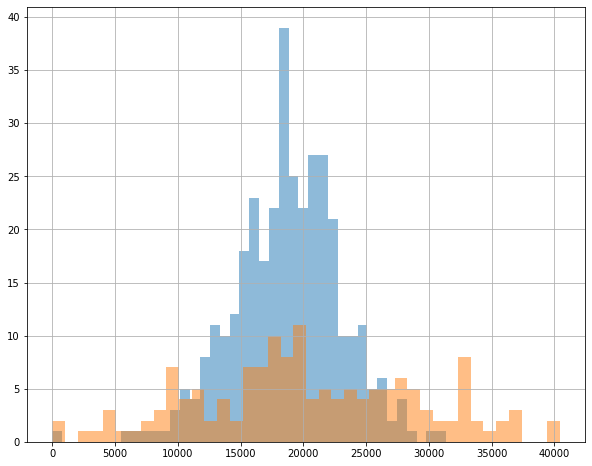

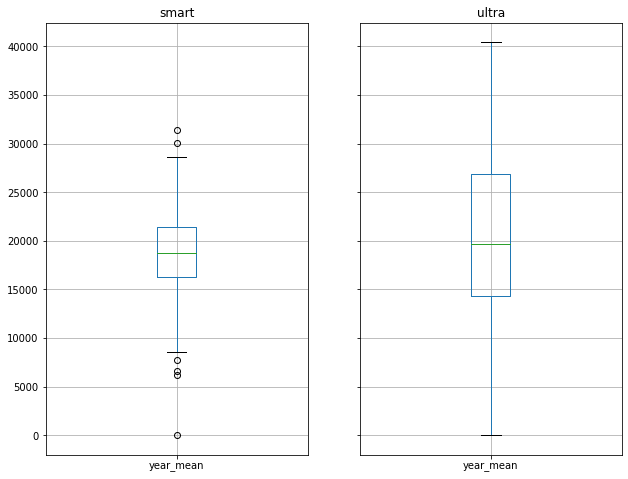

In [142]:
pivot_plot(internet_pivot)

Среднее значение:
tariff
smart    501.0
ultra    626.0
Name: year_mean, dtype: float64

Дисперсия:
tariff
smart     30432.0
ultra    113837.0
Name: year_mean, dtype: float64

Стандартное отклонение
tariff
smart    174.0
ultra    337.0
Name: year_mean, dtype: float64


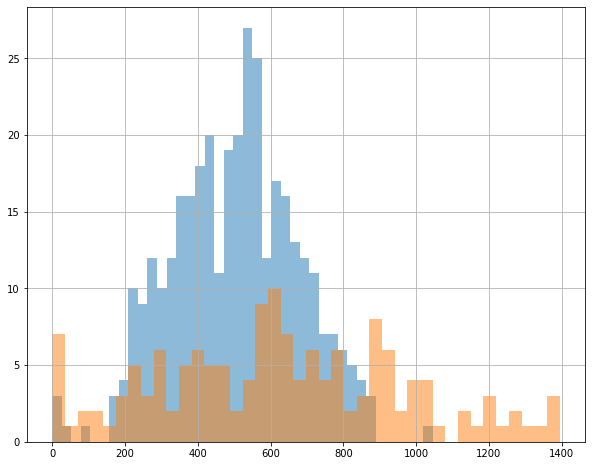

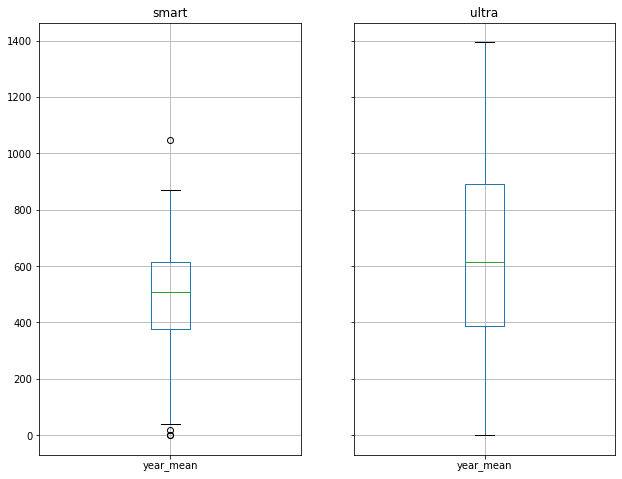

In [143]:
pivot_plot(calls_pivot)

Среднее значение:
tariff
smart    32.0
ultra    54.0
Name: year_mean, dtype: float64

Дисперсия:
tariff
smart     701.0
ultra    2149.0
Name: year_mean, dtype: float64

Стандартное отклонение
tariff
smart    26.0
ultra    46.0
Name: year_mean, dtype: float64


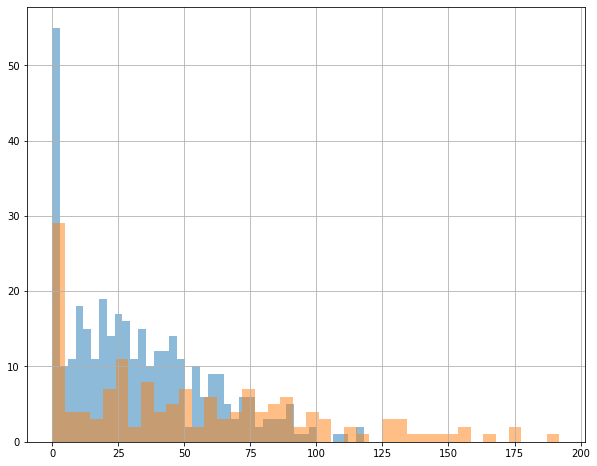

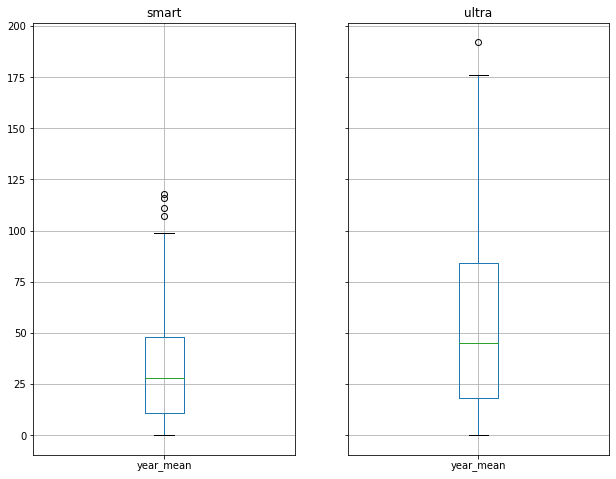

In [144]:
pivot_plot(messages_pivot)

#### Определим процент пользователей пользовавшихся предоплаченным объемом услуг связи, представив генеральную совокупность как нормально-распределенную функцию со средним значением равным среднему значению выборки и среднеквадратичным отклонением как среднеквадратичное отклонение выборки

In [147]:
def prepaid_norm(df, value, unit):
    """
    Функция определяет процент пользователей воспользовавшихся услугами в предоплаченном объеме
    """
    mu = df['year_mean'].mean()
    sigma = df['year_mean'].std()
    distr = st.norm(mu, sigma)
    p = distr.cdf(value)
    print('Процент пользователей пользовавшихся услугой связи в предоплаченном объеме ({} {}):'.format(value, unit))
    return p.round(3)*100

##### Услуги телефонной связи

In [148]:
prepaid_norm(calls_pivot.groupby('tariff').get_group('smart'), 500, 'минут')


Процент пользователей пользовавшихся услугой связи в предоплаченном объеме (500 минут):


49.8

In [149]:
prepaid_norm(calls_pivot.groupby('tariff').get_group('ultra'), 3000, 'минут')


Процент пользователей пользовавшихся услугой связи в предоплаченном объеме (3000 минут):


100.0

##### Услуги мобильного интернета

In [150]:
prepaid_norm(internet_pivot.groupby('tariff').get_group('smart'), 15360, 'Мб')

Процент пользователей пользовавшихся услугой связи в предоплаченном объеме (15360 Мб):


21.4

In [151]:
prepaid_norm(internet_pivot.groupby('tariff').get_group('ultra'), 30720, 'Мб')

Процент пользователей пользовавшихся услугой связи в предоплаченном объеме (30720 Мб):


88.0

##### Услуги СМС

In [152]:
prepaid_norm(messages_pivot.groupby('tariff').get_group('smart'), 50, 'sms')

Процент пользователей пользовавшихся услугой связи в предоплаченном объеме (50 sms):


74.7

In [153]:
prepaid_norm(messages_pivot.groupby('tariff').get_group('ultra'), 1000, 'sms')

Процент пользователей пользовавшихся услугой связи в предоплаченном объеме (1000 sms):


100.0

## Вывод по шагу 3.
#### Интернет:
- Пользователи тарифа Смарт в среднем потребляют 18736 Мб трафика в месяц со среднеквадратичным отклонением 4257 Мб, при этом предоплачено по тарифу 15360 Мб.
- Пользователи тарифа Ультра в среднем потребляют 20368 Мб трафика в месяц со среднеквадратичным отклонением 8804 Мб, при этом предоплачено по тарифу 30720 Мб.

#### Звонки:
- Пользователи тарифа Смарт разговаривают в среднем 501 минуту в месяц со среднеквадратичным отклонением в 174 минуты, при этом предоплачено по тарифу 500 минут разговора.
- Пользователи тарифа Ультра разговаривают в среднем 626 минут в месяц со среднеквадратичным отклонением в 337 минут, при этом предоплачено по тарифу 3000 минут разговора.

#### Сообщения:
- Пользователи тарифа Смарт отправляют в среднем 32 сообщения в месяц со среднеквадратичным отклонением в 26 сообщений, при этом 50 сообщений.
- Пользователи тарифа Ультра отправляют в среднем 54 сообщения в месяц со среднеквадратичным отклонением в 46 сообщений, при этом предоплачено 1000 сообщений.

Большей части пользователей тарифа Ультра хватает предоплаченого объема услуг связи:
- 100% пользователей не выговаривают 3000 минут,
- 100% пользователей не отправляют более 1000 смс,
- 88% пользователей не используют более 30Гб трафика.

Иная ситуация с пользователями тарифа Смарт:
- более 50% пользователей разговаривают больше 500 минут,
- более 78% тратит больше 15Гб интернета,
- почти 25% отправляют больше 50 смс.

## Шаг 4. Проверьте гипотезы

In [154]:
for column in range(1,13):
    cost[column] = pd.to_numeric(cost[column])

#### Добавим к сводной таблице затрат название тарифа и город для каждого пользователя

In [155]:
cost = add_column(cost, columns = ['city', 'tariff'])

In [156]:
cost['year_mean'] = cost.apply(count_year_mean, axis =1)

In [157]:
cost

1       2       3       4       5       6       7       8  \
user_id                                                                  
1000       NaN     NaN     NaN     NaN  1950.0  1950.0  1950.0  1950.0   
1001       NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1002       NaN     NaN     NaN     NaN     NaN   550.0  1950.0  2150.0   
1003       NaN     NaN     NaN     NaN     NaN     NaN     NaN  1950.0   
1004       NaN     NaN     NaN     NaN  1950.0  1950.0  1950.0  1950.0   
...        ...     ...     ...     ...     ...     ...     ...     ...   
1495       NaN     NaN     NaN     NaN     NaN     NaN     NaN  1950.0   
1496     550.0  4684.0  3573.0  3128.0  3175.0  2872.0  3606.0  3377.0   
1497       NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1498       NaN     NaN     NaN     NaN     NaN     NaN   550.0  2986.0   
1499       NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

              9      10      11      12         city tariff  year_mean  
user_id                                                                 
1000     1950.0  1950.0  1950.0  1950.0    Краснодар  ultra     1950.0  
1001        NaN     NaN  1834.0   828.0       Москва  smart     1331.0  
1002     1750.0   950.0  1950.0  1750.0  Стерлитамак  smart     1579.0  
1003     1950.0  1950.0  1950.0  1950.0       Москва  ultra     1950.0  
1004     1950.0  1950.0  1950.0  1950.0  Новокузнецк  ultra     1950.0  
...         ...     ...     ...     ...          ...    ...        ...  
1495     2550.0  2250.0  3300.0  1950.0      Иркутск  ultra     2400.0  
1496     3918.0  4136.0  4730.0  2922.0      Вологда  smart     3390.0  
1497        NaN   856.0   950.0  2358.0    Челябинск  smart     1388.0  
1498     3189.0  2350.0     NaN     NaN  Владикавказ  smart     2269.0  
1499      550.0  2501.0  2365.0   847.0        Пермь  smart     1566.0  

[500 rows x 15 columns]

Среднее значение:
             1       2       3       4       5       6       7       8  \
tariff                                                                   
smart    865.0  1116.0  1623.0  1352.0  1721.0  1707.0  1748.0  1888.0   
ultra   1950.0  2000.0  2059.0  2032.0  2107.0  2071.0  2154.0  2135.0   

             9      10      11      12  year_mean  
tariff                                             
smart   1809.0  1955.0  1949.0  2253.0     1870.0  
ultra   2058.0  2102.0  2132.0  2189.0     2125.0  

Дисперсия:
               1         2         3         4         5          6  \
tariff                                                                
smart   505123.0  628992.0  974455.0  723967.0  969678.0  1012947.0   
ultra        0.0   28696.0   92061.0   66515.0  248477.0   146644.0   

                7          8         9         10         11         12  \
tariff                                                                    
smart   1005830.0  1122404.0  

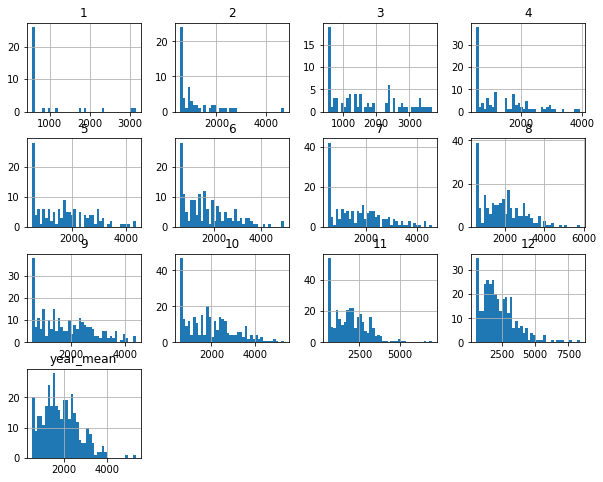

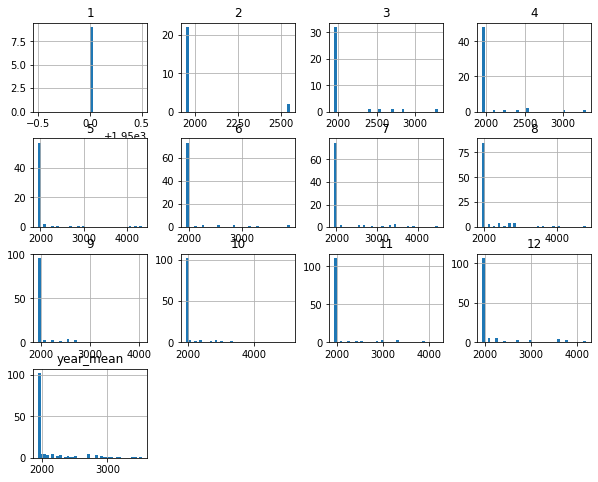

In [158]:
pivot_plot(cost, all_hist=True)

Среднее значение:
tariff
smart    1870.0
ultra    2125.0
Name: year_mean, dtype: float64

Дисперсия:
tariff
smart    683781.0
ultra    127197.0
Name: year_mean, dtype: float64

Стандартное отклонение
tariff
smart    827.0
ultra    357.0
Name: year_mean, dtype: float64


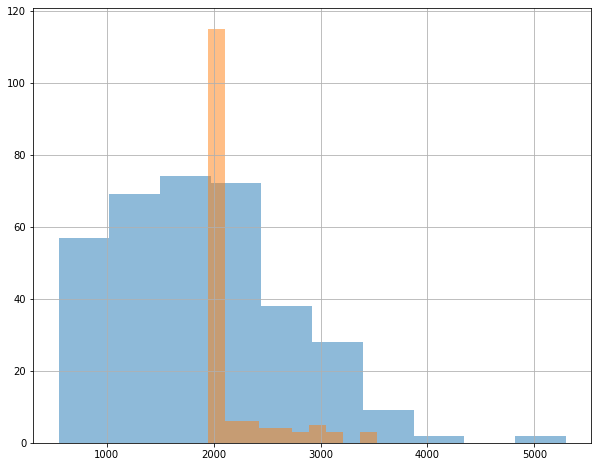

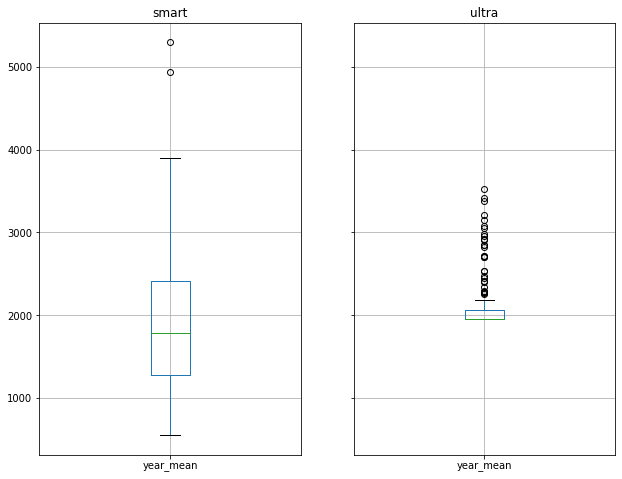

In [159]:
pivot_plot(cost, b=10)

#### Сформулируем нулевую гипотезу: Средние значения выручки тарифов Ультра и Самрт равны
#### Альтернативаня гипотеза: Средние значения выручки тарифа Ультра больше тарифа Смарт

In [160]:
alpha = 0.01

In [165]:
print('Среднее значение выручки пользователей тарифа Ultra: {:.2f}'.format(cost.groupby('tariff').get_group('ultra')['year_mean'].mean()))
print('Среднее значение выручки пользователей тарифа Smart: {:.2f}'.format(cost.groupby('tariff').get_group('smart')['year_mean'].mean()))
results =  st.ttest_ind(
    cost.groupby('tariff').get_group('ultra')['year_mean'],
    cost.groupby('tariff').get_group('smart')['year_mean'])
print('p-значение: {:.5f}'.format(results.pvalue))

Среднее значение выручки пользователей тарифа Ultra: 2125.41
Среднее значение выручки пользователей тарифа Smart: 1869.62
p-значение: 0.00031


In [166]:
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Отвергаем нулевую гипотезу


#### Сформулируем нулевую гипотезу: Выручка пользователей из Москвы равна выручке пользователей из других регионов
#### Альтернативная гипотеза: Выручка пользователей из Москвы меньше выручки пользователей из других регионов

In [167]:
print('Средняя выручка пользователей Москвы: {:.2f}'.format(cost.query('city == "Москва"')['year_mean'].mean()))
print('Средняя выручка пользователей других регионов: {:.2f}'.format(cost.query('city != "Москва"')['year_mean'].mean()))
results1 =  st.ttest_ind(
    cost.query('city == "Москва"')['year_mean'],
    cost.query('city != "Москва"')['year_mean'])
print('p-значение: {:.5f}'.format(results1.pvalue))

Средняя выручка пользователей Москвы: 1872.04
Средняя выручка пользователей других регионов: 1964.06
p-значение: 0.26091


In [168]:
if (results1.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Не получилось отвергнуть нулевую гипотезу


## Выводы по шагу 4
К сводной таблице затрат на связь для каждого пользователя в месяц были добавлены столбцы с названием используемого тарифа и региона использования.

#### Были проверены гипотезы:
1. Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.
    - Так как нулевая гипотиза формулируется так чтобы использовать знак равенства, сформулируем ее так: 
    ##### Средняя выручка на тарифах Смарт и Ультра равны.
    - Альтернативная гипотеза, так как выборочное среднее значение выручки тарифа Ультра больше чем у тарифа Смарт: 
    ##### Выручка тарифа Ультра больше Выручки тарифа Смарт.
    - Величина статистической значимости выбрана в 1%.
    - Полученное значение p-value составило 0,0003 и говорит о том, что средние значения двух генеральных совокупностей (выручки тарифов Смарт и Ультра) равны с вероятностью 0,03%, что маловероятно.
    - Нулевая гипотеза была отвергнута и принята альтернативная: 
    ##### Среднее значение выручки тарифа Ультра больше тарифа Смарт.
2. Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.
    - Аналогично предыдущему пункту сформулирована нулевая гипотеза: 
    ##### Выручка пользователей из Москвы равна выручке пользователей из других регионов.
    - Альтернативная, так как среднее выборочное значение пользователей из других регионов больше: 
    ##### Средняя выручка пользователей из Москвы ниже средней выручки пользователей из других регионов.
    - Величина статистической значимости выбрана в 1%.
    - Полученное значение p-value составило 0,2609 и говорит о том, что средние значения двух генеральных совокупностей (выручка пользователей из Москвы и выручка пользователей из других регионов) равны с вероятностью 26%. Значение много больше величины статистической значимости, поэтому: 
    ##### Нулевая гипотеза принимается.

##### Для обоих гипотез использовался критерий равенства дисперсий выборок из генеральных совокупностей.


# Общий вывод:

#### Анализ данных клиентов мобильного оператора показал:
1. Выручка от пользователей тарифа Ультра больше выручки от пользователей тарифа Смарт.
2. Среднее выборочное значение выручки тарифов Ультра и Смарт различаются на 255р или 13%.
3. Выручка от пользователей обоих тарифов в Москве и регионах, вероятно, равны.
4. У пользователей тарифа Ультра почти не бывает перерасхода минут разговора и СМСок, и несколько чаще бывает перерасход трафика (12% пользователей используют более 30Гб в месяц)
5. Больше половины пользователей тарифа Смарт разговаривают дольше предоплаченного времени, 78% тратит больше трафика, 25% отправляют больше СМСок.
6. Комерческому департаменту следует скорректировать рекламный бюджет в сторону тарифа Ультра, так как средний пользователь тарифа приносит компании большую выручку, при том что услуги связи в большинстве остаются невостребованны.
7. Альтернативным вариантом может быть снижение объема предоплаченых услуг тарифа Ультра.